# <center>Oil Viscosity</center>

The viscosity of an oil can factor into many calculations that are needed in the response of a spill, such as spreading and dispersion.

## <center>Importing and Estimating Initial Values</center>

In the PyGnome oil library, kinematic viscosity is primarily used, although the imported oil records sometimes do contain dynamic viscosity measurements.<br>
We would like to maintain as much of the useful imported information as we can.  So when we do encounter imported records with dynamic viscosities, we convert them to kinematic for use with the oil library.

The conversion from dynamic viscosity to kinematic viscosity is:

$$
\begin{align}
\eta0_{oil} &= \text{the dynamic viscosity of our oil in } Pa \cdot s \left( \text{aka } {kg \over m \cdot s} \right) \cr
\rho0_{oil} &= \text{the density of our oil in } kg/m^3 \cr
v0_{oil} &= {\eta0_{oil} \over \rho0_{oil} } = \text{the kinematic viscosity of our oil in } m^2 / s
\end{align}
$$

### <u>Some Examples</u>

Ok, let's apply this to some examples using records in our oil library.<br>
First we will import some things from our oil library that we will need.

In [1]:
import numpy as np
from oil_library import get_oil, get_oil_props, _get_db_session
from oil_library.models import (Base, ImportedRecord, Oil,
                                Density, KVis, DVis,
                                Toxicity, Category)
from oil_library.oil_props import OilProps

session = _get_db_session()

Now we can query for an oil that we are interested in.

#### Example 1:  Estimating Kinematic Viscosity

For this example, we will examine an oil that has no kinematic viscosities, but does in fact have a measured dynamic viscosity.

In [2]:
# query all imported records that have DVis but no KVis
recs = (session.query(ImportedRecord)
        .join(DVis)
        .outerjoin(KVis)
        .filter(KVis.imported_record_id == None)
        .all())
print len(recs)

# query all Oils associated with our imported records.
oils = [r.oil for r in recs if r.oil is not None]
print len(oils)

# now let's choose one that matches our example precisely
oil_obj = [o for o in oils
           if (len(o.imported.densities) == 0)][0]
print oil_obj
print oil_obj.imported.dvis
print oil_obj.imported.kvis

128
126
<Oil("KUWAIT EXPORT")>
[<DVis(0.0581 kg/ms at 310.9278K)>]
[]


The imported record for this oil contains a dynamic viscosity, but no kinematic viscosity.  So we will need to convert it to a kinematic viscosity using the method above.<br>
So in order to do that, we need to get the density for this oil.

In [3]:
print oil_obj.imported.densities
print oil_obj.imported.api

[]
31.4


Alright, you can see that the imported record for this oil also has no densities, but it does have an API.  So of course we will need to convert the API to a density at $ 15^\circ C $.<br>
Fortunately, the oil object already has this estimated.<br>
<i>(For details on this, please see the Oil density discussion )</i>

In [4]:
print oil_obj.densities

[<Density(868.631062001 kg/m^3 at 288.15K)>]


Now, is this the density value we want?  Not really, because we would really like to know what the oil density is at $ 310.93^\circ K $

For a full discussion of calculating the oil density at a temperature, please see the Oil Density notebook document.  But for our purposes, we will use the convenience function density_at_temp() located in the PyGnome oil_library module.

It takes a reference density, a reference temperature, and an optional expansion coefficient.

There is a default expansion coefficient of 0.0008 used by this utility function.  This is a reasonable average estimate, but in this case we want to verify that the oil's viscosity is close to what we would expect.  So we will also get the expansion coefficient that is used by the record.

In [5]:
from oil_library.utilities.estimations import density_at_temp
from oil_library.imported_record.estimations import ImportedRecordWithEstimation

# we need a good expansion coefficient from our imported record
imp_rec = ImportedRecordWithEstimation(oil_obj.imported)
expansion_coeff = imp_rec._vol_expansion_coeff(imp_rec.get_densities(), 310.9278)
print 'Expansion Coefficient: ', expansion_coeff

density_at_311k = density_at_temp(oil_obj.densities[0].kg_m_3,
                                  oil_obj.densities[0].ref_temp_k,
                                  310.9278,
                                  expansion_coeff)
print 'density at 311K: ', density_at_311k


Expansion Coefficient:  0.0009
density at 311K:  851.181817714


Alright, now we have the dynamic viscosity and the density.  Now we can calculate the kinematic viscosity at $ 310.93^\circ K $

In [6]:
dvis = oil_obj.imported.dvis[0]
dvis.kg_ms
kinematic_viscosity_at_311k = dvis.kg_ms / density_at_311k
print kinematic_viscosity_at_311k

6.82580369914e-05


Ok, let's see if that is what was estimated for our oil.

In [7]:
print oil_obj.kvis

[<KVis(6.82580369914e-05 m^2/s at 310.9278K)>]


Sure enough, the oil object has a kinematic value that matches our work.

#### Example 2:  Dynamic Viscosities must be at unique temperatures.

In [8]:
oil_obj = (session.query(Oil)
           .filter(Oil.name == 'DESTIN DOME CIS, MMS')
           .one())
print oil_obj
print oil_obj.imported.dvis
print oil_obj.imported.kvis

<Oil("DESTIN DOME CIS, MMS")>
[<DVis(0.00274 kg/ms at 313.15K)>]
[<KVis(3.16e-06 m^2/s at 313.15K)>]


This record has both a dynamic and kinematic density at $ 313^\circ K $. 

If an oil record has both a kinematic and dynamic viscosity at a particular temperature, we will prefer the kinematic.  

In [9]:
print oil_obj.kvis

[<KVis(3.16e-06 m^2/s at 313.15K)>]


However any dynamic viscosities that exist at unique temperatures will be converted to kinematic and used.

In [10]:
oil_obj = (session.query(Oil)
           .filter(Oil.name == 'ROSSIIELF, RUSSIAN JOINT STOCK CO')
           .one())
print oil_obj
print oil_obj.imported.dvis
print oil_obj.imported.kvis

<Oil("ROSSIIELF, RUSSIAN JOINT STOCK CO")>
[<DVis(0.12 kg/ms at 273.15K)>]
[<KVis(1.957e-05 m^2/s at 313.15K)>, <KVis(1.395e-05 m^2/s at 323.15K)>]


This oil has a couple of kinematic viscosities, but also has a dynamic viscosity at a temperature that does not match any of the kinematic viscosities.<br>
Here we will convert the dynamic viscosity and add it to the list of kinematic viscosities.

In [11]:
print oil_obj.kvis

[<KVis(0.000129914529915 m^2/s at 273.15K)>, <KVis(1.957e-05 m^2/s at 313.15K)>, <KVis(1.395e-05 m^2/s at 323.15K)>]


<hr style="height:3px">

## <center>Finding Oil Viscosity at Temperature</center>

So now that we have initial measured viscosities and their respective reference temperatures, we will need to estimate the oil's viscosity at a certain temperature or temperatures in order to provide reasonable viscosity values for a PyGnome model.

Estimating Viscosity at a certain temperature is done using the following formula:

$$
\begin{align}
v_{ref} &= \text{A measured reference viscosity} \cr
T_{ref} &= \text{The temperature at which the reference viscosity was measured} \cr
T_{pp} &= \text{The pour point (the point at which the substance stops behaving like a fluid)} \cr
T &= \text{The temperature at which we would like to compute the viscosity} \cr
k_{v2} &= \text{The Viscosity Temperature Parameter} \cr
\cr
v_{max} &= v_{ref} exp \left( k_{v2} \cdot \left[ \frac 1{T_{pp}} - \frac 1{T_{ref}} \right] \right) \cr
v_0 &= \left[ v_{ref} exp \left( k_{v2} \cdot \left[ \frac 1T - \frac 1{T_{ref}} \right] \right) \right]^{\bot v_{max}}_{ \top 0} \cr
\end{align}
$$

Alright, most of the parameters above are self-explanatory, and coming up with reasonable values for them is fairly straightforward.<br>
But what is a reasonable value for $ k_{v2} $?

Well, Payne et al (1982) recommend that $ k_{v2} = 9000^\circ K $.  But Adios 2, based on the results of several oil measurements recorded in the Environment Canada database, instead uses $ k_{v2} = 5000^\circ K $.

The formula above has been packaged as a function in the oil library.  Here is its import location

In [12]:
from oil_library.utilities.estimations import kvis_at_temp

In addition, it has been packaged to work within oil objects.

### <u>Some Examples</u>

Here we will get an oil with a number of measured kinematic viscosities and make a graph of the interpolated viscosities as a function of temperature.

In [13]:
from pylab import *

%matplotlib inline

Alright, first let's get our oil.

In [21]:
oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD02448').one()
print oil_obj

<Oil("LUCKENBACH FUEL OIL")>


Ok, now we need to determine a good temperature range that we can use to graph our viscosities.

In [15]:
oil_obj.kvis

[<KVis(0.245 m^2/s at 288.7056K)>,
 <KVis(0.0641 m^2/s at 294.2611K)>,
 <KVis(0.0225 m^2/s at 299.8167K)>,
 <KVis(0.00458 m^2/s at 310.9278K)>]

In [16]:
from oil_library.utilities.estimations import pour_point_from_kvis
pour_point_from_kvis(oil_obj.kvis[0].m_2_s,
                     oil_obj.kvis[0].ref_temp_k)

267.02016700827045

It seems that a range from $ 250^\cdot K - 350^\cdot K $ will work.

(0.0, 273.15)
(108.57010857010857, 288.15)
(12.0, 289.15)


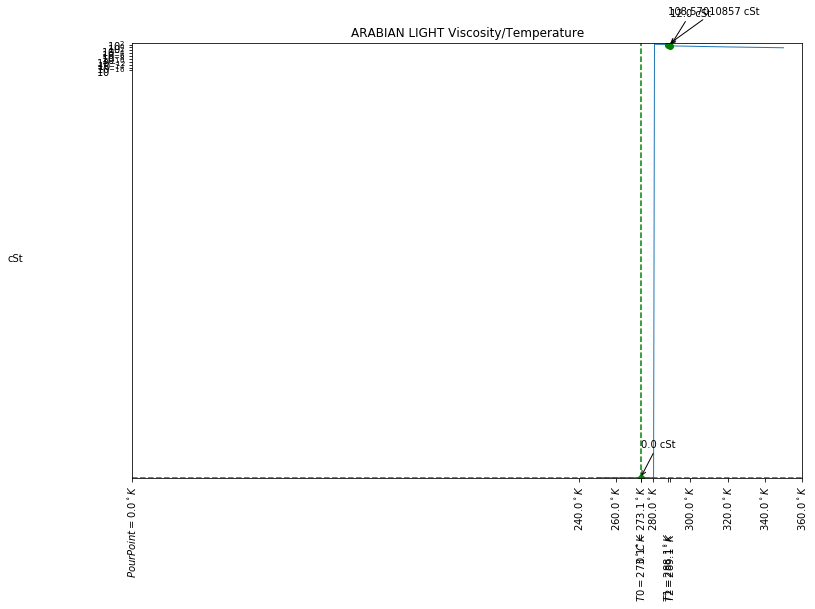

In [47]:
plt.figure(1, figsize=(12,8))
ax = plt.subplot(111)

#oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD02448').one()
oil_obj = session.query(Oil).filter(Oil.adios_oil_id == 'AD00051').one()
imp_rec = ImportedRecordWithEstimation(oil_obj.imported)

temps = np.linspace(250.0, 350.0, 200)
kvis_ref_temps = [v.ref_temp_k for v in oil_obj.kvis]
kvis_refs = [v.m_2_s * 1e6 for v in oil_obj.kvis]
for v, t in zip(kvis_refs, kvis_ref_temps):
    print (v, t)

pour_point = pour_point_from_kvis(oil_obj.kvis[0].m_2_s,
                                  oil_obj.kvis[0].ref_temp_k)

x = temps
y = imp_rec.kvis_at_temp(temps) * 1e6

graph_max = np.max(y) * 10
graph_min = np.min(y) / 10

plot(x, y, linewidth=1)
axis([np.min(temps), np.max(temps), graph_min, graph_max])
ax.axvline(273.15, color='g', ls='--')
ax.axhline(0, color='g', ls='--')

ax.set_title('{0} Viscosity/Temperature'.format(oil_obj.name))
figtext(-0.02, 0.5, 'cSt')

# annotations
for v, t in zip(kvis_refs, kvis_ref_temps):
    ax.plot(t, v, marker='o', color="green")
    ax.annotate('{0} cSt'.format(v),
                xy=(t, v),  xycoords='data',
                xytext=(0, 30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->")
                )

# generate x ticks
kvis_ref_ticks = [(v, r'$T{0}={1:.1f}^\circ K$                '.format(i, v))
                  for i, v in enumerate(kvis_ref_temps)]
x_ticks = [(v, r'${0:.1f}^\circ K$'.format(v)) for v, l in zip(*plt.xticks())]
x_ticks += kvis_ref_ticks
x_ticks += [(273.15, r'$0^\circ C={0:.1f}^\circ K$'.format(273.15))]
x_ticks += [(pour_point, r'$PourPoint = {0:.1f}^\circ K$'.format(pour_point))]
plt.xticks(*zip(*x_ticks))
plt.yscale('log', nonposy='clip')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small')
    tick.label.set_rotation('vertical')

show()

It seems visually intuitive from looking at the above graph that the rate at which the kinematic viscosity decreases with temperature, a rate that is calculated using the above formula, does not in fact match our data points.  It seems that we may need to implement something that will adjust the rate somehow.